In [2]:
from deep_traffic_generation.tcvae_pairs_disent import TCVAE_Pairs_disent
from deep_traffic_generation.VAE_Generation import PairsVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDatasetPairsRandom
from traffic.core import Traffic

import openturns as ot
import otmorris
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from tqdm import tqdm

ERROR 1: PROJ: proj_create_from_database: Open of /home/kruu/.conda/envs/mac_estimation/share/proj failed


# Get input distribution

In [3]:
dataset = TrafficDatasetPairsRandom.from_file(
    ("../../deep_traffic_generation/data/training_datasets/to_LSZH_16_50_bb.pkl", "../../deep_traffic_generation/data/training_datasets/ga_LSZH_14_50_bb.pkl"),
    features=["track", "groundspeed", "altitude", "timedelta"],
    n_samples = 10000,
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

path = "../../deep_traffic_generation/lightning_logs/tcvae_pairs_disent/version_22/"

t = PairsVAE(X = dataset, vae_type="TCVAEPairs_disent", sim_type = "generation")
t.load(path, dataset.parameters)
g = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler)  

Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../deep_traffic_generation/lightning_logs/tcvae_pairs_disent/version_22/checkpoints/epoch=981-step=12766.ckpt`


In [4]:
Z = t.latent_space(0)
p_z = t.VAE.lsr.get_prior()

marginals = []
for i in range(Z.shape[1]):
    collDist = [ot.Normal(mu.item(), sigma.item()) for mu, sigma in zip(p_z.base_dist.component_distribution.base_dist.loc.squeeze(2)[i], p_z.base_dist.component_distribution.base_dist.scale.squeeze(2)[i])]
    weights = p_z.base_dist.mixture_distribution.probs[i].detach().numpy()
    mixt = ot.Mixture(collDist, weights)
    marginals.append(mixt)
prior = ot.ComposedDistribution(marginals)

# Limit State Function

In [5]:
def limit_state(z):
    diam = 55
    
    z = np.array(z).reshape(1,-1)
    z = torch.Tensor(z)
    
    #Decode latent representation into a pair of trajectories
    decoded = t.decode(z)
    to = g.build_traffic(decoded[:,:200], coordinates = dict(latitude =  47.44464, longitude = 8.55732), forward=True).iterate_lazy().resample("1s").eval()
    # to = to.assign(flight_id=lambda x: x.flight_id + "_to", inplace=True)
    ga = g.build_traffic(decoded[:,200:], coordinates = dict(latitude = 47.500086, longitude = 8.51149), forward=True).iterate_lazy().resample("1s").eval() 
    # ga = ga.assign(flight_id=lambda x: x.flight_id + "_ga", inplace=True)
    
    # Calulate distance between the two trajectories
    dist = to[0].distance(ga[0])
    dist["3d_distance"] = dist.apply(lambda x: ((x.lateral*1852)**2 + (x.vertical*0.3048)**2)**0.5 - diam, axis=1) #distance between two spheres in m
    min_dist = dist["3d_distance"].min()
    
    return [min_dist]

In [18]:
f = ot.PythonFunction(10, 1, limit_state)

# Morris experiment

In [26]:
# number of trajectories
r=10

# p-levels
p=5
morris_experiment = otmorris.MorrisExperimentGrid([p] * prior.getDimension(), r)
bounds = ot.Interval([-5]*10,[5]*10,[True]*10, [True]*10) #[-5,5]^10
X = morris_experiment.generate()
Y = f(X)

/home/kruu/.conda/envs/mac_estimation/lib/python3.10/site-packages/traffic/core/flight.py:1719: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  value = getattr(data.iloc[:, idx], meth)()
/home/kruu/.conda/envs/mac_estimation/lib/python3.10/site-packages/traffic/core/flight.py:1721: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  value = value.fillna(method="pad")
/home/kruu/.conda/envs/mac_estimation/lib/python3.10/site-packages/traffic/core/flight.py:1719: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  value = getattr(data.iloc[:, idx], meth)()
/home/kruu/.conda/envs/mac_estimation/lib/python3.10/site-packages/traffic/core/flight.py:1721: FutureWarning

In [27]:
# Evaluate Elementary effects (ee)
morris = otmorris.Morris(X, Y, bounds)

In [32]:
from openturns.viewer import View

# Compute mu/sigma
mean = morris.getMeanAbsoluteElementaryEffects()
sigma = morris.getStandardDeviationElementaryEffects()
graph = morris.drawElementaryEffects(0)

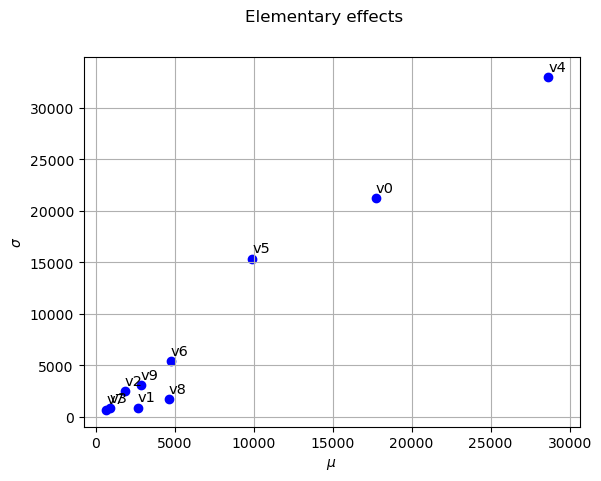

In [33]:
View(graph).show()